In [5]:
%pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
import random
from math import exp
from math import log
from collections import defaultdict
import numpy as np
import time
import torch
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
import kagglehub
from sklearn.preprocessing import OneHotEncoder

In [7]:
# path2 = kagglehub.dataset_download('thedevastator/online-course-student-engagement-metrics', path='Courses.csv')
# print("path 2 :  " , path2)

path2 = "Courses.csv"
df = pd.read_csv(path2)  # Windows-1252 encoding
print(df.head())

   index                   course_id       userid_DI  registered  viewed  \
0      0  HarvardX/CB22x/2013_Spring  MHxPC130442623           1       0   
1      1         HarvardX/CS50x/2012  MHxPC130442623           1       1   
2      2  HarvardX/CB22x/2013_Spring  MHxPC130275857           1       0   
3      3         HarvardX/CS50x/2012  MHxPC130275857           1       0   
4      4  HarvardX/ER22x/2013_Spring  MHxPC130275857           1       0   

   explored  certified final_cc_cname_DI LoE_DI  YoB  ... grade start_time_DI  \
0         0          0     United States    NaN  NaN  ...     0    2012-12-19   
1         0          0     United States    NaN  NaN  ...     0    2012-10-15   
2         0          0     United States    NaN  NaN  ...     0    2013-02-08   
3         0          0     United States    NaN  NaN  ...     0    2012-09-17   
4         0          0     United States    NaN  NaN  ...     0    2012-12-19   

  last_event_DI nevents  ndays_act  nplay_video  nchapte

In [8]:
df2 = df[["course_id"  , "userid_DI"]]
print(df2.head())
print(df2.shape)

                    course_id       userid_DI
0  HarvardX/CB22x/2013_Spring  MHxPC130442623
1         HarvardX/CS50x/2012  MHxPC130442623
2  HarvardX/CB22x/2013_Spring  MHxPC130275857
3         HarvardX/CS50x/2012  MHxPC130275857
4  HarvardX/ER22x/2013_Spring  MHxPC130275857
(641138, 2)


In [9]:
# Check if CUDA is available
device = torch.device('cuda')
print(f"Using device: {device}")


Using device: cuda


In [10]:
class KNN(object):

    def __init__(self, numUsers, numItems,batchSize , epochs , trainData,  learningRate  , lamI = 6e-2, lamJ = 6e-3,):
        self._numUsers = numUsers
        self._numItems = numItems
        self._lamI = lamI
        self._lamJ = lamJ
        self._learningRate = learningRate
        self._users = set()
        self._items = set()
        self._Iu = defaultdict(set)
        self.C = torch.rand(numItems, numItems)  # Random correlation matrix
        self._batchSize = batchSize
        self._epochs = epochs
        self.trainData = trainData


    def predict(self, u, i):  
        # print("predict called")
        # Calculate the predicted score for user u and item i  
    
        # Create a list 'l' containing items associated with user u (course_DI)  
        l = self.trainData[self.trainData['userid_DI'] == u]['course_id'].tolist()  
        
        # Remove item i from the list if it exists  
        if i in l:  
            l.remove(i)  
    
        total_score = 0  
        # print("u : " , u , " i  : " , i )
        for l_item in l:  
            total_score += self.C[i, l_item]   
    
        return total_score 
        
    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def train(self):
        
        # correlation matrix
        self.C =np.random.rand(self._numItems, self._numItems)  
        for l in range(self._numItems):
            self.C[l][l] = 0
            for n in range(l + 1, self._numItems):
                self.C[l][n] = self.C[n][l]


        # print("for loop for items*2 is done.")
        # change batch_size to min(batch-size, len(train))
        if len(self.trainData) < self._batchSize:
            sys.stderr.write("WARNING: Batch size is greater than number of training samples, switching to a batch size of %s\n" % str(len(self.trainData)))
            self._batchSize = len(self.trainData)
                  
        self._trainDict, self._users, self._items = self._dataPretreatment(self.trainData)
        N = len(self.trainData) * self._epochs
        users, pItems, nItems = self._sampling(N)
        itr = 0
        t2 = t0 = time.time()


        '''While Loop:
            
            The loop continues as long as the condition (itr + 1) * self._batchSize < N is true. This means the loop will run until the next batch would exceed the total number of samples.
            Inside the loop, the _mbgd method is called with slices of the users, pItems, and nItems arrays. This method presumably performs the training step for the current mini-batch of data.
            Batch Processing:
            
            The slicing operation users[itr*self._batchSize: (itr+1)*self._batchSize] retrieves the current batch of user data, and similarly for positive and negative items.
            After processing the current batch, itr is incremented to move to the next batch.
            Time Tracking and Progress Output:
            
            t2 = time.time() captures the current time after processing the batch.
            The progress of training is printed to standard error using sys.stderr.write. It shows how many samples have been processed, the percentage of total samples processed, and the time taken since the start of training (t0).
            sys.stderr.flush() ensures that the output is immediately written to the console, which is useful for monitoring long-running training processes.
            Final Output:
            
            After the loop completes, if N is greater than 0 (indicating that there were samples to process), a summary of the total training time and the average samples processed per second is printed.'''
        while (itr+1)*self._batchSize < N:
            # print("iter : " ,  itr , " batch size : "  , self._batchSize)
      
            self._mbgd(
                users[itr*self._batchSize: (itr+1)*self._batchSize],
                pItems[itr*self._batchSize: (itr+1)*self._batchSize],
                nItems[itr*self._batchSize: (itr+1)*self._batchSize]
            )
            
            itr += 1
            t2 = time.time()
            sys.stderr.write("\rProcessed %s ( %.3f%% ) in %.1f seconds" %(str(itr*self._batchSize), 100.0 * float(itr*self._batchSize)/N, t2 - t0))
            sys.stderr.flush()
        if N > 0:
            sys.stderr.write("\nTotal training time %.2f seconds; %.2f samples per second\n" % (t2 - t0, N*1.0/(t2 - t0)))
            sys.stderr.flush()

    '''The function _mbgd implements a mini-batch gradient descent algorithm for optimizing a collaborative filtering model, particularly focusing on user-item interactions. 
    It takes three arguments: users, pItems, and nItems, which represent the users, positive items, and negative items, respectively. 
    The function initializes a variable prev to track the previous objective function value and runs for a fixed number of iterations (30). Within each iteration, 
    it calculates the gradient for each unique user-item interaction based on the current model parameters stored in self.C, using a sigmoid function to derive the objective value related to the difference between predicted preferences for positive and negative items. 
    The computed gradients are accumulated, and an objective score (obj) is updated, incorporating regularization terms based on self._lamI and self._lamJ to prevent overfitting. 
    If the new objective value indicates no improvement (i.e., it is less than the previous objective), the loop breaks early. Finally, gradients are applied to update the model parameters using a specified learning rate (self._learningRate). 
    The method effectively learns optimal item representations iteratively while balancing the trade-off between fitting the observed data and maintaining regularity through penalization terms.'''
            
    def _mbgd(self, users, pItems, nItems):
        
        prev = -2**10
        for _ in range(30):
            
            gradientC = defaultdict(float)
            obj = 0

            for ind in range(len(users)):
                u, i, j = users[ind], pItems[ind], nItems[ind]
                x_ui = sum([self.C[i][l] for l in self._Iu[u] if i != l])
                x_uj = sum([self.C[j][l] for l in self._Iu[u]])
                x_uij =  x_ui - x_uj
                
                for l in self._Iu[u]:
                    if l != i:
                        gradientC[(i,l)] += (1-self.sigmoid(x_uij)) + self._lamI * self.C[i][l]**2
                        gradientC[(l,i)] += (1-self.sigmoid(x_uij)) + self._lamI * self.C[l][i]**2
                    gradientC[(j,l)] += -(1-self.sigmoid(x_uij)) + self._lamJ * self.C[j][l]**2
                    gradientC[(l,j)] += -(1-self.sigmoid(x_uij)) + self._lamJ * self.C[l][j]**2
                    
                    obj -= 2*self._lamI * self.C[i][l]**2 + 2*self._lamJ * self.C[j][l]**2
                    
                obj += log(self.sigmoid(x_uij))
            
            #print 'OBJ: ', obj
            if prev > obj: 
                break
            prev = obj
            
            for a,b in gradientC:
                self.C[a][b] += self._learningRate * gradientC[(a,b)]
            
        #print _, '\n'
        
    def _sampling(self, N):
        print(f"Generating {N} random training samples")
        userList = list(self._users)
        
        # Generate all random numbers at once
        userIndex = np.random.randint(0, len(self._users), N)
        pItems = []
        nItems = []
        
        # Process in smaller chunks
        chunk_size = 1000
        for chunk_start in range(0, N, chunk_size):
            chunk_end = min(chunk_start + chunk_size, N)
            chunk_indices = userIndex[chunk_start:chunk_end]
            
            for index in chunk_indices:
                u = userList[index]
                # Get positive item
                i = self._trainDict[u][np.random.randint(len(self._Iu[u]))]
                pItems.append(i)
                
                # Get negative item more efficiently
                j = np.random.randint(self._numItems)
                while j in self._Iu[u]:
                    j = np.random.randint(self._numItems)
                nItems.append(j)
            
            # print(f"Generated {chunk_end}/{N} samples ({(chunk_end/N)*100:.1f}%)")
        
        print("Sampling completed!")
        return userIndex, pItems, nItems

    
    def predictionsKNN(self, K, u):
        # Convert the correlation matrix to a PyTorch tensor if it's not already
        if not isinstance(self.C, torch.Tensor):
            self.C = torch.tensor(self.C, dtype=torch.float32)

        # Check if the user has any items
        if not self._Iu[u]:
            print(f"User {u} has no items.")
            return torch.zeros(self._numItems)  # Return a zero tensor or handle as needed

        if K >= len(self._Iu[u]):
            # Use PyTorch sum and indexing
            res = torch.sum(torch.stack([self.C[:, l] for l in self._Iu[u]]), dim=0)
        else:
            res = []
            for i in range(self._numItems):
                # Use PyTorch operations for sorting and summing
                item_scores = torch.tensor([self.C[i][l] for l in self._Iu[u]], dtype=torch.float32)
                top_k_scores = torch.topk(item_scores, K).values
                res.append(torch.sum(top_k_scores).item())
        return res
    

    # def prediction(self, u, i):
    #     scores = self.predictionsAll(u)
    #     # Fix the index calculation
    #     return scores[i] > sorted(scores)[int(self._numItems * 0.8)]
    

    # def prediction(self, u, i):
        
    #     scores = self.predictionsAll(u)
    #     return scores[i] > sorted(scores)[self._numItem*0.8]

    def _dataPretreatment(self, data):
        # print(" control is here")
        dataDict = defaultdict(list)
        items = set()
        ind = 0
        for index , rows in data.iterrows():
            ind+=1
            u = rows['userid_DI']

            i = rows['course_id']
            # print("user : " , u , "item : " , i)
            self._Iu[u].add(i)
            dataDict[u].append(i)
            items.add(i)

        # print("data dicts are : " , dataDict , dataDict.keys , items)
        return dataDict, set(dataDict.keys()), items

In [11]:
#  Create mapping dictionaries
course_id_map = {id_: idx for idx, id_ in enumerate(df2['course_id'].unique())}
user_id_map = {id_: idx for idx, id_ in enumerate(df2['userid_DI'].unique())}

# Create new dataframe with mapped values
df2_numeric = df2.copy()
df2_numeric['course_id'] = df2['course_id'].map(course_id_map)
df2_numeric['userid_DI'] = df2['userid_DI'].map(user_id_map)

# Print first 15 rows of numeric data
i = 0
for index, rows in df2_numeric.iterrows():
    i += 1
    if(i > 15):
        break
    print(rows['course_id'], rows['userid_DI'])


user_course_counts = df2_numeric.groupby('userid_DI')['course_id'].nunique()

# Print users with their course counts, sorted by count
print("\nUsers and their course counts:")
print(user_course_counts.sort_values().head(10))  # Show 10 users with least courses
print("\nSummary statistics:")
print(f"Average courses per user: {user_course_counts.mean():.2f}")
print(f"Median courses per user: {user_course_counts.median():.2f}")
print(f"Max courses by a user: {user_course_counts.max()}")
print(f"Min courses by a user: {user_course_counts.min()}")

0 0
1 0
0 1
1 1
2 1
3 1
4 1
0 2
0 3
1 3
2 3
2 4
0 5
1 5
2 5

Users and their course counts:
userid_DI
476518    1
476519    1
476520    1
476521    1
476522    1
476523    1
476524    1
476525    1
476528    1
12        1
Name: course_id, dtype: int64

Summary statistics:
Average courses per user: 1.35
Median courses per user: 1.00
Max courses by a user: 16
Min courses by a user: 1


In [12]:
# Create train/test splits following leave-one-out evaluation scheme

'''It prints a message indicating that the train-test split is being created.
It selects a random sample of one record for each user, identified by the 'userid_DI' column, to be included in the test set. This is done by grouping the DataFrame by user ID and applying a sampling function.
The indices of these randomly selected records are stored in the test_indices array.
A new DataFrame test_df is created using the rows of df that correspond to the selected test indices.
The training DataFrame train_df is created by dropping the test indices from the original DataFrame df.
It prints a message indicating that the train-test split is complete.
Finally, it returns the training DataFrame train_df and the testing DataFrame test_df'''



def create_train_test_split(df):
    print("creating train-test split")
    
    # Get random indices for test set - one per user
    test_indices = df.groupby('userid_DI').apply(
        lambda x: x.sample(n=1).index[0],
        include_groups=False
    ).values
    
    # Create test and train dataframes using boolean indexing
    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    print("done with test-train split")
    
    return train_df, test_df

# splitting into training and testing data
train_df, test_df = create_train_test_split(df2_numeric)

creating train-test split
done with test-train split


In [13]:
'''Input Parameters:

train_df: A DataFrame containing training data where each entry corresponds to a user and the courses they have interacted with.
test_df: A DataFrame containing testing data, similar to train_df, but used to evaluate the recommendation system.
num_items: An integer representing the total number of unique items (courses) available in the system.
sample_size: The number of negative items to sample for each testing user, with a default value of 100.
Initial Setup:

The function starts by initializing an empty dictionary named evaluation_pairs to hold the results.
It then creates a Series test_user_items which maps each user in the testing data (test_df) to the course they interacted with.
Pre-computation:

The function aggregates train user items by grouping train_df by userid_DI and applying a set operation to create a dictionary (train_user_items) where each user maps to a set of courses they have interacted with in the training data.
A set all_items is created, containing all possible item IDs based on the num_items parameter.
Generating Evaluation Pairs:

The function iterates over each unique user in the test_df.
For each user, it retrieves their positive item (the item they interacted with during testing) and their corresponding training items.
It calculates the negative items by subtracting the set of training items and the positive item from the set of all items. This yields the negative items that the user has not interacted with.

The positive item and the sampled negative items are stored in the evaluation_pairs dictionary under the corresponding user ID.
Completion and Return:

After all users have been processed, the function prints a completion message and returns the evaluation_pairs dictionary containing the evaluation data for each test user.'''


# Create evaluation pairs E(u) for each user
def create_evaluation_pairs(train_df, test_df, num_items):

    print("creating evaluation pairs")
    evaluation_pairs = {}
    
    # Pre-compute test user data
    test_user_items = test_df.set_index('userid_DI')['course_id']
    train_user_items = train_df.groupby('userid_DI')['course_id'].apply(set).to_dict()
    all_items = set(range(num_items))

    
    for user in test_df['userid_DI'].unique():
        positive_item = test_user_items[user]
        train_items = train_user_items.get(user, set())
        
        # Use set operations for faster filtering
        negative_items = list(all_items - train_items - {positive_item}) #this is x_uj , where x_uj doesn;t belong to Stest and Strain
        
            
        evaluation_pairs[user] = {
            'positive_item': positive_item,
            'negative_items': negative_items
        }

    return evaluation_pairs

import torch
import time
import sys

def calculate_auc_pytorch(model, eval_pairs):
    """
    Calculate Area Under the Curve (AUC) using the methodology described in the research paper.
    
    Args:
    - model: The recommendation model to evaluate
    - eval_pairs: A dictionary of evaluation pairs for each user
    
    Returns:
    - Average AUC across all users
    """
    auc_sum = 0.0
    user_count = 0
    t0 = time.time()
    
    for user in eval_pairs.keys():
        # Get the positive item and negative items for this user
        positive_item = eval_pairs[user]['positive_item']
        negative_items = eval_pairs[user]['negative_items']
        
        # Predict score for the positive item
        x_ui = model.predict(user, positive_item)
        
        # Predict scores for negative items
        x_uj_list = [model.predict(user, neg_item) for neg_item in negative_items]
        
        # Calculate AUC for this user
        # Count how many times the positive item score is higher than negative item scores
        auc_user = sum(x_ui > x_uj for x_uj in x_uj_list) / (len(negative_items)+1)
        
        auc_sum += auc_user
        user_count += 1
        
        # Progress tracking and occasional logging
        if user_count % 1000 == 0:
            t2 = time.time()
            # print(f"User count: {user_count}")
            # print(f"AUC sum: {auc_sum}")
            # print(f"Current user AUC: {auc_user}")
            sys.stderr.write(f"\rProcessed {user_count} which is {(user_count/len(eval_pairs.keys()))*100}% of users in {t2 - t0:.1f} seconds")
            sys.stderr.flush()
    
    # Return average AUC across all users
    final_auc = auc_sum / user_count if user_count > 0 else 0.5
    
    # Final progress update
    t_end = time.time()
    sys.stderr.write(f"\nTotal processing time: {t_end - t0:.1f} seconds\n")
    sys.stderr.write(f"Final AUC: {final_auc}\n")
    sys.stderr.flush()
    
    return final_auc

In [14]:
# # Creating evaluation pairs for calculation of auc
# eval_pairs = create_evaluation_pairs(train_df, test_df, num_items=16)
# print(type(eval_pairs))

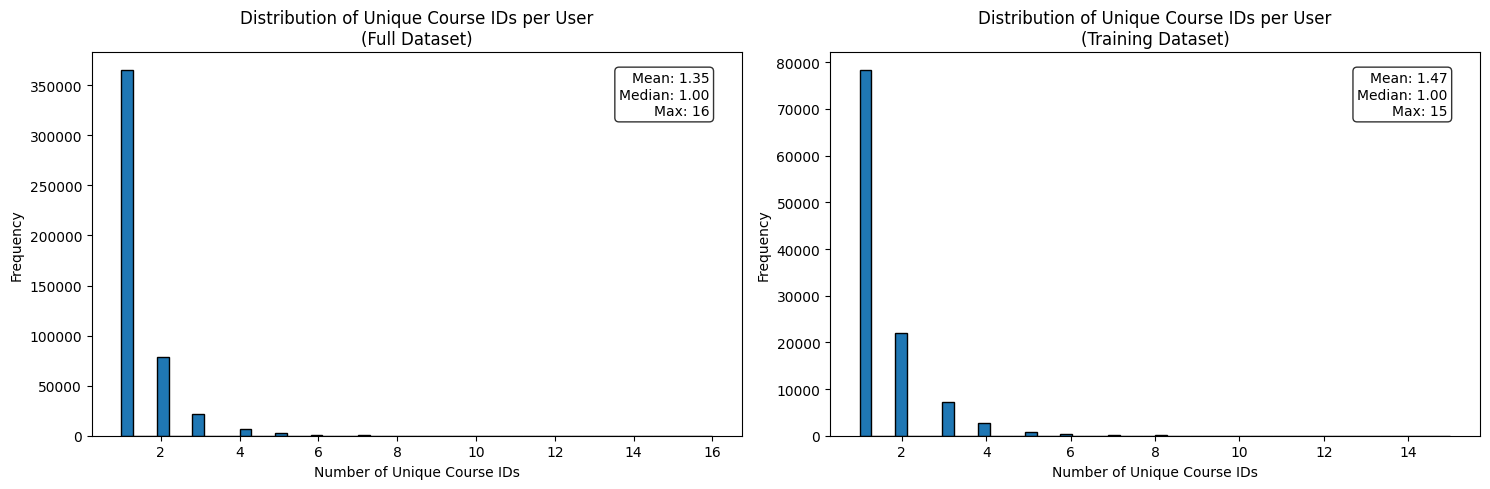

In [15]:
#plotting the distribution of courses per user for Strain and S
import matplotlib.pyplot as plt

# Calculate unique course counts per user for both datasets
full_data_counts = df2_numeric.groupby('userid_DI')['course_id'].nunique()
train_data_counts = train_df.groupby('userid_DI')['course_id'].nunique()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot histogram for full dataset
ax1.hist(full_data_counts, bins=50, edgecolor='black')
ax1.set_title('Distribution of Unique Course IDs per User\n(Full Dataset)')
ax1.set_xlabel('Number of Unique Course IDs')
ax1.set_ylabel('Frequency')

# Plot histogram for training dataset
ax2.hist(train_data_counts, bins=50, edgecolor='black')
ax2.set_title('Distribution of Unique Course IDs per User\n(Training Dataset)')
ax2.set_xlabel('Number of Unique Course IDs')
ax2.set_ylabel('Frequency')

# Add some statistics as text
ax1.text(0.95, 0.95, 
         f'Mean: {full_data_counts.mean():.2f}\nMedian: {full_data_counts.median():.2f}\nMax: {full_data_counts.max()}', 
         transform=ax1.transAxes, 
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax2.text(0.95, 0.95, 
         f'Mean: {train_data_counts.mean():.2f}\nMedian: {train_data_counts.median():.2f}\nMax: {train_data_counts.max()}', 
         transform=ax2.transAxes, 
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

Original course distribution:
count        16.00000
mean      40071.12500
std       39210.26866
min        5665.00000
25%       19310.50000
50%       30525.00000
75%       45545.50000
max      169621.00000
Name: userid_DI, dtype: float64

Balanced course distribution:
count       16.000000
mean     23800.750000
std       9538.984226
min       5665.000000
25%      19310.500000
50%      30263.500000
75%      30525.000000
max      30525.000000
Name: userid_DI, dtype: float64


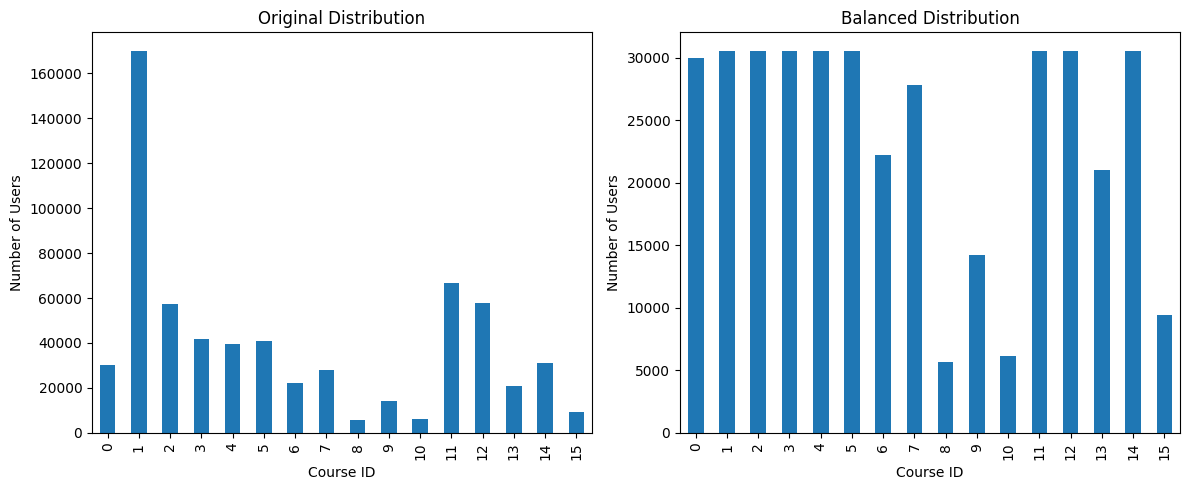

In [16]:
# 1. First, let's analyze the current distribution
course_user_counts = df2_numeric.groupby('course_id')['userid_DI'].count()
print("Original course distribution:")
print(course_user_counts.describe())

# 2. Find the median number of users per course
median_users = course_user_counts.median()

# 3. Create a balanced dataset
balanced_df = pd.DataFrame()

for course_id in df2_numeric['course_id'].unique():
    course_data = df2_numeric[df2_numeric['course_id'] == course_id]
    
    if len(course_data) > median_users:
        # Downsample courses with too many users
        sampled_data = course_data.sample(n=int(median_users), random_state=42)
        balanced_df = pd.concat([balanced_df, sampled_data])
    else:
        # Keep all data for courses with fewer users
        balanced_df = pd.concat([balanced_df, course_data])

# 4. Verify the new distribution
new_course_user_counts = balanced_df.groupby('course_id')['userid_DI'].count()
print("\nBalanced course distribution:")
print(new_course_user_counts.describe())

# 5. Plot the distributions
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
course_user_counts.plot(kind='bar')
plt.title('Original Distribution')
plt.xlabel('Course ID')
plt.ylabel('Number of Users')

plt.subplot(1, 2, 2)
new_course_user_counts.plot(kind='bar')
plt.title('Balanced Distribution')
plt.xlabel('Course ID')
plt.ylabel('Number of Users')

plt.tight_layout()
plt.show()

# 6. Use this balanced dataset for your model
df2_numeric_bal= balanced_df.reset_index(drop=True)

In [17]:
df2_numeric_bal.describe()
df2_numeric_bal.info()
df2_numeric_bal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380812 entries, 0 to 380811
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   course_id  380812 non-null  int64
 1   userid_DI  380812 non-null  int64
dtypes: int64(2)
memory usage: 5.8 MB


,course_id,userid_DI
0,0,0
1,0,1
2,0,2
3,0,3
4,0,5


In [18]:
#for balanced : 


# Sample the dataset
# df2_numeric_temp = train_df

# Calculate num_users and num_items for the current sample
num_users_bal = df2_numeric_bal['userid_DI'].nunique()
num_items_bal = df2_numeric_bal['course_id'].nunique()

# Initialize the KNN model
bpr = KNN(num_users_bal, num_items_bal, 128 , 100, df2_numeric_bal ,0.01)

# Train the model
bpr.train()

train_df_temp_bal, test_df_temp_bal = create_train_test_split(df2_numeric_bal)
eval_pairs_temp_bal = create_evaluation_pairs(df2_numeric_bal, test_df_temp_bal, num_items_bal)
print(type(eval_pairs_temp_bal))

Generating 38081200 random training samples


Processed 768 ( 0.002% ) in 0.5 seconds

Sampling completed!


Processed 38081152 ( 100.000% ) in 263.5 seconds
Total training time 263.51 seconds; 144517.06 samples per second


creating train-test split
done with test-train split
creating evaluation pairs
<class 'dict'>


In [19]:
# Evaluate the model using AUC
auc_score_bal = calculate_auc_pytorch(bpr , eval_pairs_temp_bal)
print("auc score : " , auc_score_bal)

Processed 134000 which is 44.283759757298554% of users in 390.2 seconds

KeyboardInterrupt: 

In [22]:
train_df.head()
train_df.describe()
train_df.info()
len(train_df)
user_course_counts = train_df.groupby('userid_DI')['course_id'].nunique()

print("\nUsers and their course counts:")
print(user_course_counts.sort_values().head(10))  # Show 10 users with least courses
print("\nSummary statistics:")
print(f"Average courses per user: {user_course_counts.mean():.2f}")
print(f"Median courses per user: {user_course_counts.median():.2f}")
print(f"Max courses by a user: {user_course_counts.max()}")
print(f"Min courses by a user: {user_course_counts.min()}")

<class 'pandas.core.frame.DataFrame'>
Index: 164606 entries, 0 to 641137
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   course_id  164606 non-null  int64
 1   userid_DI  164606 non-null  int64
dtypes: int64(2)
memory usage: 3.8 MB

Users and their course counts:
userid_DI
476102    1
476101    1
476092    1
38        1
476470    1
229399    1
229392    1
229369    1
229361    1
229351    1
Name: course_id, dtype: int64

Summary statistics:
Average courses per user: 1.47
Median courses per user: 1.00
Max courses by a user: 15
Min courses by a user: 1


In [46]:
# # Sample the dataset
# df_sample_temp = df2_numeric

# # Calculate num_users and num_items for the current sample
# num_users = df_sample_temp['userid_DI'].nunique()
# num_items = df_sample_temp['course_id'].nunique()

# # Initialize the KNN model
# bpr = KNN(num_users, num_items, 128 ,100, df_sample_temp ,0.01)

# # Train the model
# bpr.train()

# train_df_temp, test_df_temp = create_train_test_split(df_sample_temp)
# eval_pairs_temp = create_evaluation_pairs(df_sample_temp, test_df_temp, num_items)
# print(type(eval_pairs_temp))

Generating 64113800 random training samples


KeyboardInterrupt: 

In [35]:
# # Evaluate the model using AUC
# auc_score = calculate_auc_pytorch(bpr , eval_pairs_temp)
# print("auc score : " , auc_score)

Processed 111000 which is 99.36442574523319% of users in 233.4 seconds
Total processing time: 234.9 seconds
Final AUC: 0.22850089836480897


auc score :  0.22850089836480897


Starting randomized grid search...
Generating 500000 random training samples
Generating 250000 random training samples
Generating 750000 random training samples
Generating 1500000 random training samples
Generating 1500000 random training samples
Generating 1000000 random training samples
Sampling completed!


Processed 7680 ( 3.072% ) in 0.4 seconds

Generating 750000 random training samples
Generating 250000 random training samples
Generating 500000 random training samples


Processed 11520 ( 4.608% ) in 0.6 seconds

Generating 750000 random training samples
Generating 1500000 random training samples


Processed 2816 ( 0.563% ) in 0.2 secondss

Sampling completed!


Processed 29440 ( 11.776% ) in 1.4 seconds

Sampling completed!
Generating 1000000 random training samples
Generating 1000000 random training samples


Processed 34560 ( 6.912% ) in 1.8 secondsds

Sampling completed!


Processed 190208 ( 76.083% ) in 2.6 seconds

Sampling completed!
Sampling completed!
creating train-test split


Processed 249984 ( 99.994% ) in 2.8 seconds
Total training time 2.79 seconds; 89640.72 samples per second
Processed 46848 ( 9.370% ) in 2.4 seconds

Generating 750000 random training samples
Generating 750000 random training samples


Processed 71424 ( 14.285% ) in 3.6 seconds

Sampling completed!
Sampling completed!


Processed 75520 ( 15.104% ) in 3.8 seconds

Sampling completed!
done with test-train split
creating evaluation pairs


Processed 28928 ( 3.857% ) in 2.2 secondss

Sampling completed!


Processed 512 ( 0.068% ) in 0.1 secondsonds of users in 1.4 seconds

Sampling completed!


Processed 570880 ( 57.088% ) in 7.5 secondssof users in 3.6 seconds

Sampling completed!
Sampling completed!


Processed 1499648 ( 99.977% ) in 7.1 secondsf users in 5.9 seconds
Total training time 7.13 seconds; 210451.69 samples per second
Processed 838272 ( 83.827% ) in 8.5 secondss

creating train-test split
Sampling completed!


Processed 891008 ( 89.101% ) in 8.7 secondss

Sampling completed!


Processed 999936 ( 99.994% ) in 9.2 secondss
Total training time 9.17 seconds; 109046.98 samples per second
Processed 2816 ( 0.282% ) in 0.8 secondsonds

creating train-test split


Processed 226560 ( 30.208% ) in 15.2 secondsof users in 10.5 seconds

done with test-train split
creating evaluation pairs


Processed 237056 ( 31.607% ) in 16.0 secondsof users in 12.8 seconds

done with test-train split
creating evaluation pairs


Processed 749824 ( 99.977% ) in 20.9 secondsf users in 13.3 secondsds
Total training time 20.88 seconds; 35925.45 samples per second
Processed 249600 ( 33.280% ) in 28.7 seconds

creating train-test split


Processed 499968 ( 99.994% ) in 35.7 seconds of users in 30.8 seconds
Total training time 35.74 seconds; 13990.28 samples per second
Processed 292608 ( 39.014% ) in 34.0 seconds users in 18.7 seconds

creating train-test split


Processed 474368 ( 63.249% ) in 37.9 secondsf users in 21.3 secondsds

done with test-train split
creating evaluation pairs


Processed 210560 ( 28.075% ) in 39.8 secondsf users in 6.7 secondsnds

done with test-train split
creating evaluation pairs


Processed 749952 ( 99.994% ) in 45.8 secondsof users in 46.6 secondss
Total training time 45.82 seconds; 16369.49 samples per second
Processed 588800 ( 78.507% ) in 51.0 seconds

creating train-test split


Processed 249984 ( 99.994% ) in 51.6 secondsof users in 36.6 seconds
Total training time 51.60 seconds; 4845.06 samples per second
Processed 234112 ( 46.822% ) in 49.6 seconds

creating train-test split


Processed 380672 ( 38.067% ) in 46.3 secondsof users in 18.0 secondss

done with test-train split
creating evaluation pairs


Processed 155648 ( 20.753% ) in 49.0 secondsof users in 12.3 secondss

done with test-train split
creating evaluation pairs


Processed 749824 ( 99.977% ) in 67.3 seconds of users in 29.3 seconds
Total training time 67.29 seconds; 11145.87 samples per second
Processed 302336 ( 60.467% ) in 64.3 seconds

creating train-test split


Processed 456960 ( 45.696% ) in 60.2 secondsf users in 24.7 secondsds

done with test-train split
creating evaluation pairs


Processed 749824 ( 99.977% ) in 88.5 seconds of users in 51.6 seconds
Total training time 88.54 seconds; 8470.87 samples per second
Processed 407680 ( 81.536% ) in 86.9 seconds

creating train-test split


Processed 443392 ( 88.678% ) in 94.5 seconds of users in 39.1 seconds

done with test-train split
creating evaluation pairs


Processed 499968 ( 99.994% ) in 106.7 secondss users in 93.1 secondss
Total training time 106.66 seconds; 4687.67 samples per second
Processed 604800 ( 60.480% ) in 99.9 secondsds users in 71.8 seconds

creating train-test split


Processed 608256 ( 60.826% ) in 100.8 secondss users in 40.4 secondss
Total processing time: 107.6 seconds
Final AUC: 0.07926267360446271
Processed 499968 ( 33.331% ) in 111.8 secondssf users in 44.9 seconds

done with test-train split
creating evaluation pairs


Processed 918272 ( 91.827% ) in 135.7 secondss users in 47.1 secondsss
Total processing time: 107.8 seconds
Final AUC: 0.2802762499699749
Processed 999936 ( 99.994% ) in 143.9 secondss users in 96.9 secondsds
Total training time 143.87 seconds; 6950.80 samples per second
Processed 1496832 ( 99.789% ) in 151.2 seconds

creating train-test split


Processed 1499904 ( 99.994% ) in 151.5 seconds users in 137.8 seconds
Total training time 151.49 seconds; 9901.79 samples per second
Processed 592128 ( 59.213% ) in 144.3 seconds

creating train-test split


Processed 639232 ( 63.923% ) in 148.9 secondsof users in 43.5 secondss

done with test-train split
creating evaluation pairs


Processed 645888 ( 64.589% ) in 149.6 secondsf users in 89.4 secondss

done with test-train split
creating evaluation pairs


Processed 36000 which is 74.63769618311115% of users in 121.0 secondss
Total processing time: 107.5 seconds
Final AUC: 0.1453680142482414
Processed 999936 ( 99.994% ) in 184.4 secondsf users in 135.5 secondss
Total training time 184.43 seconds; 5422.06 samples per second


creating train-test split


Processed 605696 ( 80.759% ) in 190.5 secondsof users in 82.8 secondss

done with test-train split
creating evaluation pairs


Processed 812288 ( 54.153% ) in 201.2 secondsf users in 146.0 secondss
Total processing time: 148.0 seconds
Final AUC: 0.0698912484277278
Processed 862464 ( 57.498% ) in 216.6 secondsf users in 204.3 secondss
Total processing time: 161.7 seconds
Final AUC: 0.1702538105402838
Processed 749568 ( 99.942% ) in 219.3 secondsof users in 67.8 secondss
Total training time 219.33 seconds; 3419.48 samples per second


creating train-test split


Processed 913152 ( 60.877% ) in 232.1 secondsf users in 189.8 secondss

done with test-train split
creating evaluation pairs


Processed 972544 ( 64.836% ) in 248.1 secondsf users in 235.5 secondss
Total processing time: 235.9 seconds
Final AUC: 0.13759479824328344
Processed 1028608 ( 68.574% ) in 254.0 seconds users in 240.6 secondss
Total processing time: 241.0 seconds
Final AUC: 0.09707690882825316
Processed 1196288 ( 79.753% ) in 271.1 seconds users in 158.5 secondss
Total processing time: 159.0 seconds
Final AUC: 0.2868248496436133
Processed 1499904 ( 99.994% ) in 301.0 seconds users in 206.2 secondss
Total training time 301.02 seconds; 4982.98 samples per second


creating train-test split


Processed 27000 which is 19.961260368765803% of users in 73.8 secondss

done with test-train split
creating evaluation pairs


Processed 77000 which is 82.64728927624589% of users in 175.7 secondss
Total processing time: 216.3 seconds
Final AUC: 0.8786649357579949
Processed 93000 which is 99.82075198299827% of users in 215.9 seconds
Total processing time: 216.2 seconds
Final AUC: 0.9345577708791393
Processed 130000 which is 96.10977214590942% of users in 361.2 seconds
Total processing time: 207.1 seconds
Final AUC: 0.9313889238836166
Processed 116000 which is 85.75948899173456% of users in 319.8 seconds
Total processing time: 372.5 seconds
Final AUC: 0.15752143197573287
Processed 64000 which is 47.315580133370794% of users in 145.6 seconds
Total processing time: 359.2 seconds
Final AUC: 0.9308667102351629
Processed 135000 which is 99.80630184382902% of users in 305.4 seconds
Total processing time: 306.0 seconds
Final AUC: 0.8920520652261518
Processed 135000 which is 99.80630184382902% of users in 282.4 seconds
Total processing time: 282.9 seconds
Final AUC: 0.935236867435545



Best parameters found:
{
  "sample_size": 150000,
  "learning_rate": 0.001,
  "lamJ": 0.005,
  "lamI": 0.01,
  "epochs": 10,
  "batch_size": 256
}

Best AUC score: 0.935236867435545


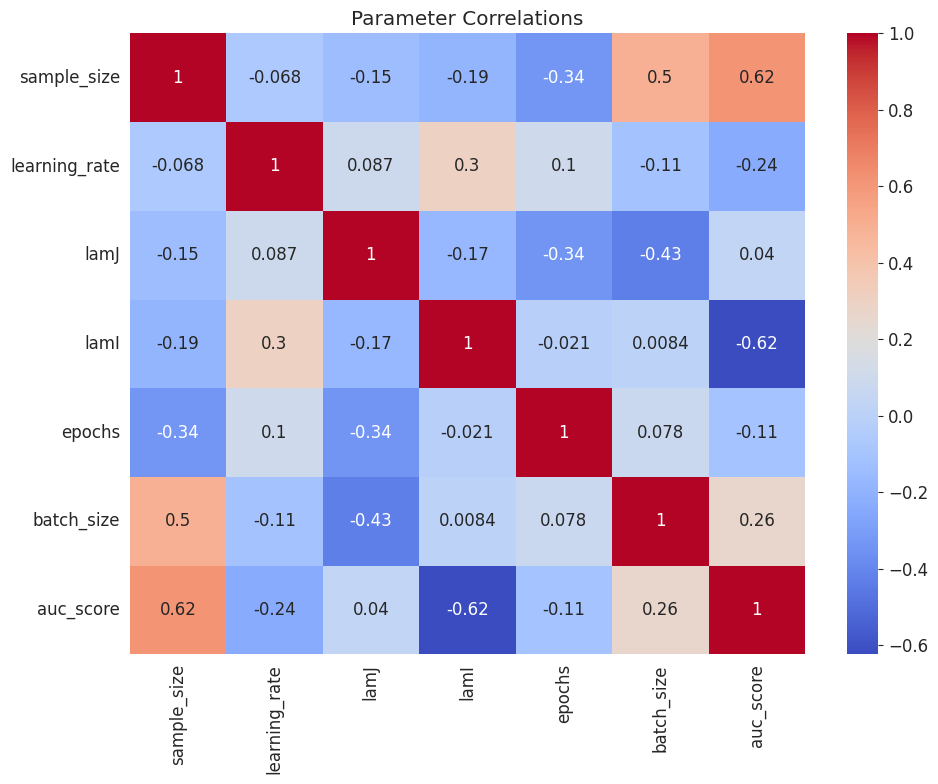

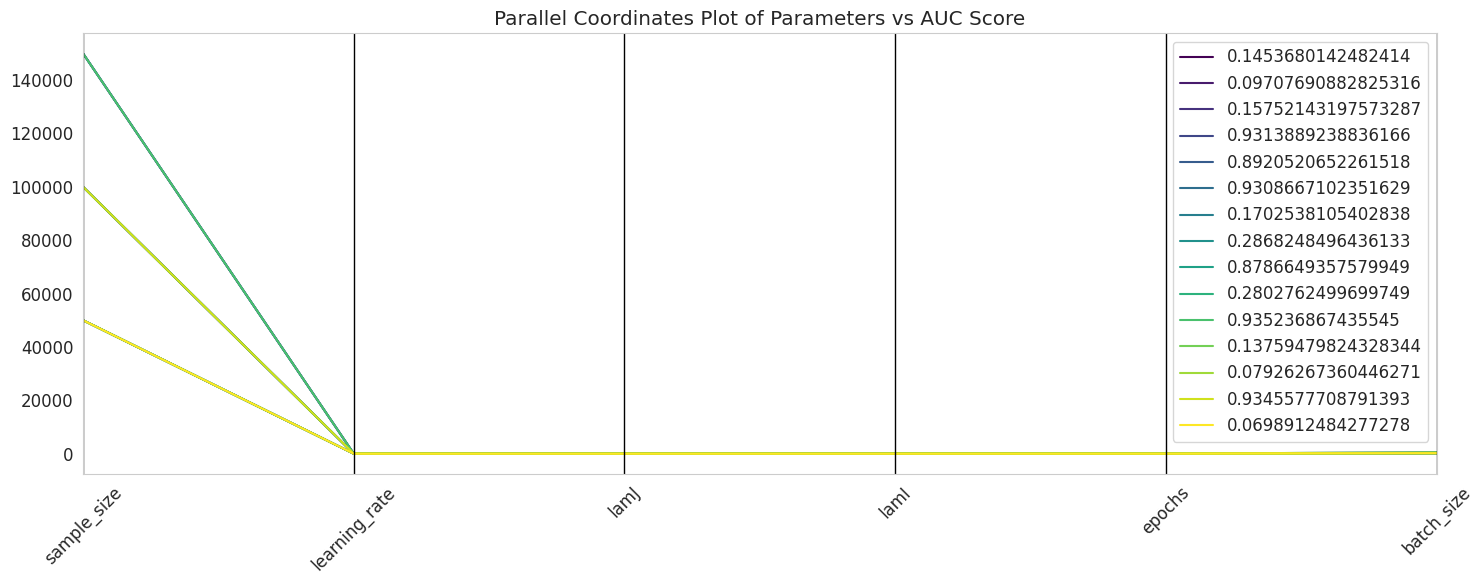

In [22]:
### GRID SEARCH : 
from sklearn.model_selection import ParameterSampler
from joblib import Parallel, delayed
import numpy as np
from datetime import datetime
import json
# Add this with your other imports
import glob

def train_and_evaluate_model(params, df_numeric, random_state=42):
    """
    Train and evaluate a single model with given parameters
    """
    try:
        # Sample the dataset if specified
        if params['sample_size'] < len(df_numeric):
            df_sample = df2_numeric_bal.sample(n=params['sample_size'], random_state=random_state)
        else:
            df_sample = df2_numeric_bal

        # Calculate num_users and num_items
        num_users = df_sample['userid_DI'].nunique()
        num_items = df_sample['course_id'].nunique()

        # Initialize and train model
        model = KNN(
            numUsers=num_users,
            numItems=num_items,
            batchSize=params['batch_size'],
            epochs=params['epochs'],
            trainData=df_sample,
            learningRate=params['learning_rate'],
            lamI=params['lamI'],
            lamJ=params['lamJ']
        )

        # Train the model
        model.train()

        # Create train-test split and evaluation pairs
        train_df, test_df = create_train_test_split(df_sample)
        eval_pairs = create_evaluation_pairs(train_df, test_df, num_items)

        # Calculate AUC score
        auc_score = calculate_auc_pytorch(model, eval_pairs)

        return {
            'params': params,
            'auc_score': auc_score,
            'status': 'success'
        }

    except Exception as e:
        return {
            'params': params,
            'auc_score': -1,
            'status': f'failed: {str(e)}'
        }

# Define parameter space
param_distributions = {
    'sample_size': [50000, 100000, 150000],
    'batch_size': [128, 256, 512],
    'epochs': [5, 10, 15],
    'learning_rate': [0.001, 0.005, 0.01],
    'lamI': [0.01, 0.025, 0.05],
    'lamJ': [0.001, 0.0025, 0.005]
}

def run_randomized_search(df_numeric, n_iter=10, n_jobs=-1, random_state=42):
    """
    Run randomized search with parallel processing
    """
    # Generate parameter combinations
    param_list = list(ParameterSampler(
        param_distributions, 
        n_iter=n_iter, 
        random_state=random_state
    ))

    # Run parallel processing
    results = Parallel(n_jobs=n_jobs)(
        delayed(train_and_evaluate_model)(
            params, 
            df_numeric, 
            random_state
        ) for params in param_list
    )

    # Process results
    successful_results = [r for r in results if r['status'] == 'success']
    
    if not successful_results:
        print("No successful trials!")
        return None

    # Find best parameters
    best_result = max(successful_results, key=lambda x: x['auc_score'])
    
    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_filename = f'grid_search_results_{timestamp}.json'
    
    with open(results_filename, 'w') as f:
        json.dump({
            'all_results': results,
            'best_result': best_result
        }, f, indent=4)

    return best_result

# Run the randomized search
if __name__ == "__main__":
    print("Starting randomized grid search...")
    best_result = run_randomized_search(
        df2_numeric_bal,
        n_iter=15,  # Number of parameter combinations to try
        n_jobs=-1,  # Use all available cores
        random_state=42
    )

    if best_result:
        print("\nBest parameters found:")
        print(json.dumps(best_result['params'], indent=2))
        print(f"\nBest AUC score: {best_result['auc_score']}")

        # Create visualization of results
        import seaborn as sns
        import matplotlib.pyplot as plt

        # Load results from saved file
        with open(max(glob.glob('grid_search_results_*.json'))) as f:
            all_results = json.load(f)['all_results']

        # Create DataFrame of successful results
        results_df = pd.DataFrame([
            {**r['params'], 'auc_score': r['auc_score']}
            for r in all_results
            if r['status'] == 'success'
        ])

        # Create correlation heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(results_df.corr(), annot=True, cmap='coolwarm')
        plt.title('Parameter Correlations')
        plt.tight_layout()
        plt.show()

        # Create parallel coordinates plot to visualize parameter relationships
        # This plot shows how different parameter combinations affect the AUC score
        # Each line represents one model configuration, colored by its AUC score
        # Parallel axes show the different parameter values used
        # Lines crossing between axes show relationships between parameters
        plt.figure(figsize=(15, 6))
        pd.plotting.parallel_coordinates(
            results_df,  # DataFrame containing parameters and scores for each run
            'auc_score', # Color lines based on AUC score
            colormap=plt.cm.viridis # Use viridis colormap - higher AUC = brighter color
        )
        plt.title('Parallel Coordinates Plot of Parameters vs AUC Score')
        plt.xticks(rotation=45) # Rotate parameter labels for readability
        plt.tight_layout() # Adjust spacing to prevent label overlap
        plt.show()


Processing sample size: 50000
Generating 500000 random training samples


Processed 1792 ( 0.358% ) in 0.2 seconds

Sampling completed!


Processed 499968 ( 99.994% ) in 61.8 seconds
Total training time 61.81 seconds; 8089.33 samples per second


creating train-test split
done with test-train split
creating evaluation pairs


Processed 48000 which is 99.51692824414819% of users in 73.2 secondss
Total processing time: 73.6 seconds
Final AUC: 0.9373456947892568
/home/iiitd/oreki/course_reccomendation/virtual/lib/python3.12/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 24 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

results: [{'sample_size': 50000, 'BPR-KNN': np.float64(0.9373456947892568), 'Implicit ALS': 0.5621577917796052, 'BPR-KNN Time': 139.85421776771545, 'Implicit ALS Time': 5.191706895828247}]

Processing sample size: 100000
Generating 1000000 random training samples


Processed 1792 ( 0.179% ) in 0.2 seconds

Sampling completed!


Processed 999936 ( 99.994% ) in 126.6 seconds
Total training time 126.59 seconds; 7899.60 samples per second


creating train-test split
done with test-train split
creating evaluation pairs


Processed 93000 which is 99.82075198299827% of users in 164.5 secondss
Total processing time: 164.8 seconds
Final AUC: 0.9371879438088835


  0%|          | 0/50 [00:00<?, ?it/s]

results: [{'sample_size': 50000, 'BPR-KNN': np.float64(0.9373456947892568), 'Implicit ALS': 0.5621577917796052, 'BPR-KNN Time': 139.85421776771545, 'Implicit ALS Time': 5.191706895828247}, {'sample_size': 100000, 'BPR-KNN': np.float64(0.9371879438088835), 'Implicit ALS': 0.5550436259379288, 'BPR-KNN Time': 298.7821750640869, 'Implicit ALS Time': 10.533636331558228}]

Processing sample size: 75000
Generating 750000 random training samples


Processed 1792 ( 0.239% ) in 0.2 seconds

Sampling completed!


Processed 749952 ( 99.994% ) in 93.1 seconds
Total training time 93.12 seconds; 8054.47 samples per second


creating train-test split
done with test-train split
creating evaluation pairs


Processed 71000 which is 99.87199504859969% of users in 117.1 seconds
Total processing time: 117.2 seconds
Final AUC: 0.9372672907171143


  0%|          | 0/50 [00:00<?, ?it/s]

results: [{'sample_size': 50000, 'BPR-KNN': np.float64(0.9373456947892568), 'Implicit ALS': 0.5621577917796052, 'BPR-KNN Time': 139.85421776771545, 'Implicit ALS Time': 5.191706895828247}, {'sample_size': 100000, 'BPR-KNN': np.float64(0.9371879438088835), 'Implicit ALS': 0.5550436259379288, 'BPR-KNN Time': 298.7821750640869, 'Implicit ALS Time': 10.533636331558228}, {'sample_size': 75000, 'BPR-KNN': np.float64(0.9372672907171143), 'Implicit ALS': 0.5569809371071774, 'BPR-KNN Time': 215.63968133926392, 'Implicit ALS Time': 7.593993425369263}]


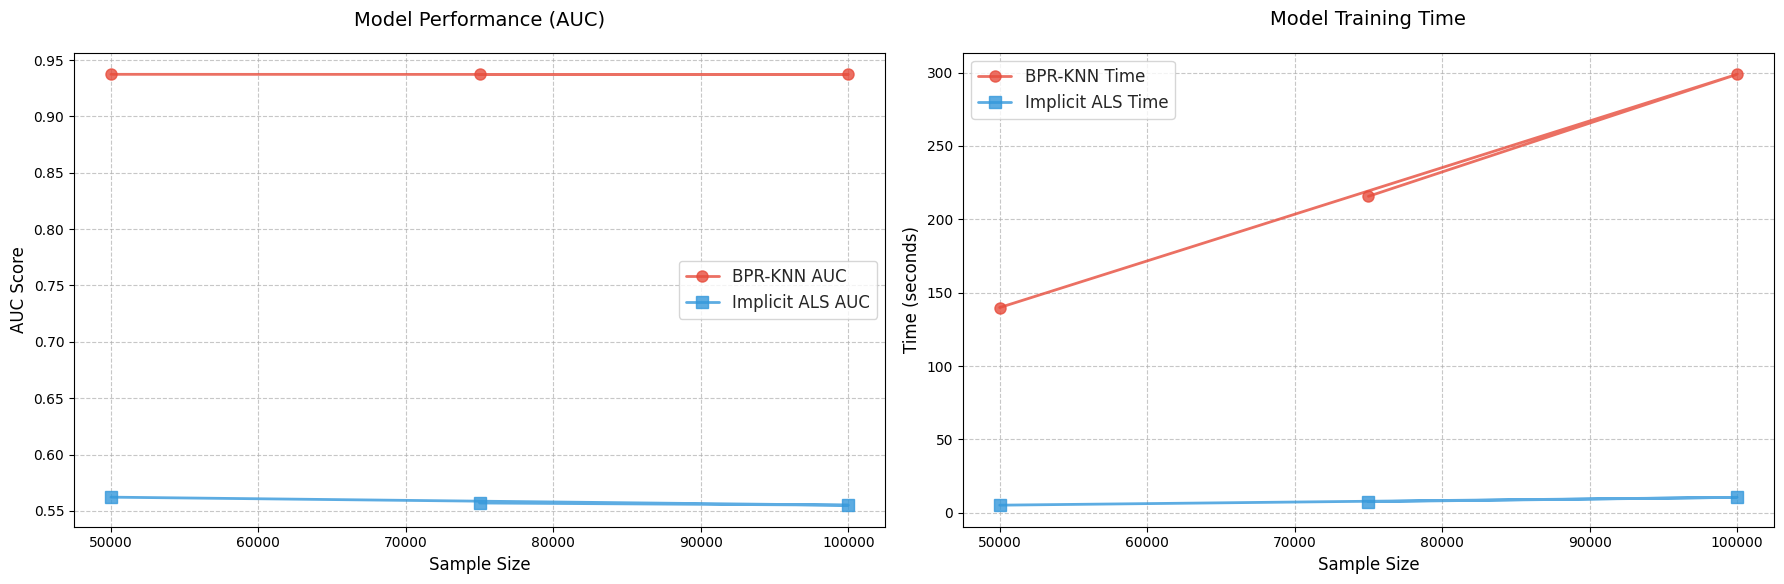

In [21]:
import numpy as np
import pandas as pd
import time
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import train_test_split, AUC_at_k
from scipy.sparse import csr_matrix

def compare_models(df_balanced, sample_sizes):
    results = []
    
    for sample_size in sample_sizes:
        print(f"\nProcessing sample size: {sample_size}")
        
        # Sample the data
        df_sample = df_balanced.sample(n=min(sample_size, len(df_balanced)), random_state=42)
        
        try:
            # Remap user and item IDs to consecutive integers
            user_map = {old: new for new, old in enumerate(df_sample['userid_DI'].unique())}
            item_map = {old: new for new, old in enumerate(df_sample['course_id'].unique())}
            
            df_sample_mapped = df_sample.copy()
            df_sample_mapped['userid_DI'] = df_sample['userid_DI'].map(user_map)
            df_sample_mapped['course_id'] = df_sample['course_id'].map(item_map)
            
            num_users = len(user_map)
            num_items = len(item_map)
            
            # Initialize a new BPR-KNN model for each sample size
            start_time = time.time()
            bpr = KNN(num_users, num_items, 128, 10, df_sample_mapped, 0.01, lamI=0.01, lamJ=0.005)
            bpr.train()
            train_df, test_df = create_train_test_split(df_sample_mapped)
            eval_pairs = create_evaluation_pairs(train_df, test_df, num_items)
            auc_bpr = calculate_auc_pytorch(bpr, eval_pairs)
            bpr_time = time.time() - start_time
            
            # Implicit ALS
            sparse_matrix = csr_matrix(
                (np.ones(len(df_sample_mapped)),
                 (df_sample_mapped['userid_DI'].values, df_sample_mapped['course_id'].values)),
                shape=(num_users, num_items)
            )
            
            # Split data using implicit's built-in function
            train_matrix, test_matrix = train_test_split(sparse_matrix, train_percentage=0.8)
            
            # Initialize and train model
            start_time = time.time()
            model = AlternatingLeastSquares(
                factors=50,
                regularization=0.01,
                alpha=1.0,
                iterations=50
            )
            model.fit(train_matrix)
            auc_implicit = AUC_at_k(
                model,
                train_matrix,
                test_matrix,
                K=10,
                show_progress=False,
                num_threads=0
            )
            implicit_time = time.time() - start_time
            
            results.append({
                'sample_size': sample_size,
                'BPR-KNN': auc_bpr if auc_bpr is not None else 0.0,
                'Implicit ALS': auc_implicit if auc_implicit is not None else 0.0,
                'BPR-KNN Time': bpr_time,
                'Implicit ALS Time': implicit_time
            })
            print("results:", results)
            
        except Exception as e:
            print(f"Error at sample size {sample_size}: {str(e)}")
            print("Full traceback:", traceback.format_exc())
            results.append({
                'sample_size': sample_size,
                'BPR-KNN': 0.0,
                'Implicit ALS': 0.0,
                'BPR-KNN Time': 0.0,
                'Implicit ALS Time': 0.0
            })
    
    return pd.DataFrame(results).set_index('sample_size')

# Run comparison with sample sizes
sample_sizes = [50000, 100000, 75000]  # Starting with smaller sizes for testing
results_df = compare_models(df2_numeric_bal, sample_sizes)

# Plotting the results
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# Plot AUC scores
axes[0].plot(
    results_df.index,
    results_df['BPR-KNN'],
    marker='o',
    color='#e74c3c',  # Red for BPR-KNN
    label='BPR-KNN AUC',
    linewidth=2,
    markersize=8,
    alpha=0.8
)
axes[0].plot(
    results_df.index,
    results_df['Implicit ALS'],
    marker='s',
    color='#3498db',  # Blue for Implicit ALS
    label='Implicit ALS AUC',
    linewidth=2,
    markersize=8,
    alpha=0.8
)
axes[0].set_title('Model Performance (AUC)', fontsize=14, pad=20)
axes[0].set_xlabel('Sample Size', fontsize=12)
axes[0].set_ylabel('AUC Score', fontsize=12)
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.7)

# Plot Time taken
axes[1].plot(
    results_df.index,
    results_df['BPR-KNN Time'],
    marker='o',
    color='#e74c3c',  # Red for BPR-KNN
    label='BPR-KNN Time',
    linewidth=2,
    markersize=8,
    alpha=0.8
)
axes[1].plot(
    results_df.index,
    results_df['Implicit ALS Time'],
    marker='s',
    color='#3498db',  # Blue for Implicit ALS
    label='Implicit ALS Time',
    linewidth=2,
    markersize=8,
    alpha=0.8
)
axes[1].set_title('Model Training Time', fontsize=14, pad=20)
axes[1].set_xlabel('Sample Size', fontsize=12)
axes[1].set_ylabel('Time (seconds)', fontsize=12)
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'lightfm'